In [28]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

#Change working directory to make it easier to access the files
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/dinn")
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/dinn'

In [29]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

polio_data = genfromtxt('polio.csv', delimiter=',') #in the form of [t, Sc  ,Sa  ,Ic  ,Ia  ,Rc  ,Ra ]

torch.manual_seed(1234)

In [30]:
%%time

PATH = 'polio' 

class DINN(nn.Module):
    def __init__(self, t ,Sc_data ,Sa_data ,Ic_data ,Ia_data ,Rc_data ,Ra_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.Sc = torch.tensor(Sc_data)
        self.Sa = torch.tensor(Sa_data)
        self.Ic = torch.tensor(Ic_data)
        self.Ia = torch.tensor(Ia_data)
        self.Rc = torch.tensor(Rc_data)
        self.Ra = torch.tensor(Ra_data)

        self.Na = torch.tensor(908.8)
        self.Nc = torch.tensor(91.19999999999999) 
        self.N = torch.tensor(1000) 

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learself.nable parameters
        self.mu_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.02)
        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0.5)
        self.gamma_a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(18)
        self.gamma_c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(36)
        self.beta_aa_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(40)
        self.beta_cc_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(90)
        self.beta_ac_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0)
        self.beta_ca_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))#torch.tensor(0)

        #matrices (x6 for Sc ,Sa ,Ic ,Ia ,Rc ,Ra) for the gradients
        self.m1 = torch.zeros((len(self.t), 6)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 6)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 6)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 6)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 6)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 6)); self.m6[:, 5] = 1

        #values for norm
        self.Sc_max = max(self.Sc)
        self.Sc_min = min(self.Sc)
        self.Sa_max = max(self.Sa)
        self.Sa_min = min(self.Sa)
        self.Ic_max = max(self.Ic)
        self.Ic_min = min(self.Ic)
        self.Ia_max = max(self.Ia)
        self.Ia_min = min(self.Ia)
        self.Rc_max = max(self.Rc)
        self.Rc_min = min(self.Rc)
        self.Ra_max = max(self.Ra)
        self.Ra_min = min(self.Ra)
        
        #normalize 
        self.Sc_hat = (self.Sc - self.Sc_min)/(self.Sc_max - self.Sc_min)
        self.Sa_hat = (self.Sa - self.Sa_min)/(self.Sa_max - self.Sa_min)
        self.Ic_hat = (self.Ic - self.Ic_min)/(self.Ic_max - self.Ic_min)
        self.Ia_hat = (self.Ia - self.Ia_min)/(self.Ia_max - self.Ia_min)
        self.Rc_hat = (self.Rc - self.Rc_min)/(self.Rc_max - self.Rc_min)
        self.Ra_hat = (self.Ra - self.Ra_min)/(self.Ra_max - self.Ra_min)

        #NN
        self.net_polio = self.Net_polio()
        self.params = list(self.net_polio.parameters())
        self.params.extend(list([self.mu_tilda ,self.alpha_tilda ,self.gamma_a_tilda ,self.gamma_c_tilda ,self.beta_aa_tilda ,self.beta_cc_tilda ,self.beta_ac_tilda ,self.beta_ca_tilda]))

        
    #force parameters to be in a range
    @property
    def mu(self):
        return torch.tanh(self.mu_tilda) * 0.002 + 0.02
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda) * 0.005 + 0.5
    @property
    def gamma_a(self):
        return torch.tanh(self.gamma_a_tilda) * 0.1 + 18
    @property
    def gamma_c(self):
        return torch.tanh(self.gamma_c_tilda) * 0.2 + 36
    @property
    def beta_aa(self):
        return torch.tanh(self.beta_aa_tilda) + 40
    @property
    def beta_cc(self):
        return torch.tanh(self.beta_cc_tilda) + 90
    @property
    def beta_ac(self):
        return torch.tanh(self.beta_ac_tilda) * 0.001
    @property
    def beta_ca(self):
        return torch.tanh(self.beta_ca_tilda) * 0.001

    #nets
    class Net_polio(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_polio, self).__init__()
            self.fc1=nn.Linear(1, 64) #takes 100 t's
            self.fc2=nn.Linear(64, 64)
            self.fc3=nn.Linear(64, 64)
            self.fc4=nn.Linear(64, 64)
            self.fc5=nn.Linear(64, 64)
            self.fc6=nn.Linear(64, 64)
            self.fc7=nn.Linear(64, 64)
            self.fc8=nn.Linear(64, 64)
            self.out=nn.Linear(64, 6) #outputs Sc  ,Sa  ,Ic  ,Ia  ,Rc  ,Ra 

        def forward(self, t):
            polio=F.relu(self.fc1(t))
            polio=F.relu(self.fc2(polio))
            polio=F.relu(self.fc3(polio))
            polio=F.relu(self.fc4(polio))
            polio=F.relu(self.fc5(polio))
            polio=F.relu(self.fc6(polio))
            polio=F.relu(self.fc7(polio))
            polio=F.relu(self.fc8(polio))
            polio=self.out(polio)
            return polio    

    def net_f(self, t_batch):       

        polio_hat = self.net_polio(t_batch)

        Sc_hat  ,Sa_hat  ,Ic_hat  ,Ia_hat  ,Rc_hat  ,Ra_hat  = polio_hat[:,0], polio_hat[:,1], polio_hat[:,2], polio_hat[:,3], polio_hat[:,4], polio_hat[:,5]

        #Sc_hat
        polio_hat.backward(self.m1, retain_graph=True)
        Sc_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Sa_hat
        polio_hat.backward(self.m2, retain_graph=True)
        Sa_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ic_hat
        polio_hat.backward(self.m3, retain_graph=True)
        Ic_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ia_hat
        polio_hat.backward(self.m4, retain_graph=True)
        Ia_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Rc_hat
        polio_hat.backward(self.m5, retain_graph=True)
        Rc_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ra_hat
        polio_hat.backward(self.m6, retain_graph=True)
        Ra_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        Sc = self.Sc_min + (self.Sc_max - self.Sc_min) * Sc_hat
        Sa = self.Sa_min + (self.Sa_max - self.Sa_min) * Sa_hat
        Ic = self.Ic_min + (self.Ic_max - self.Ic_min) * Ic_hat
        Ia = self.Ia_min + (self.Ia_max - self.Ia_min) * Ia_hat
        Rc = self.Rc_min + (self.Rc_max - self.Rc_min) * Rc_hat
        Ra = self.Ra_min + (self.Ra_max - self.Ra_min) * Ra_hat
     
        #equations
        f1_hat = Sc_hat_t - (self.mu*self.N - (self.alpha+self.mu+(self.beta_cc/self.Nc) *Ic + (self.beta_ca/self.Nc) *Ia) * Sc) / (self.Sc_max - self.Sc_min)
        f2_hat = Sa_hat_t - (self.alpha*Sc - (self.mu + (self.beta_aa/self.Na)*Ia + (self.beta_ac/self.Na)*Ic)*Sa) / (self.Sa_max - self.Sa_min)
        f3_hat = Ic_hat_t - (((self.beta_cc/self.Nc)*Ic + (self.beta_ca/self.Nc)*Ia)*Sc - (self.gamma_c+self.alpha+self.mu)*Ic) / (self.Ic_max - self.Ic_min)
        f4_hat = Ia_hat_t - (((self.beta_ac/self.Na)*Ic + (self.beta_aa/self.Na)*Ia)*Sa - (self.gamma_a+self.mu)*Ia +self.alpha*Ic) / (self.Ia_max - self.Ia_min)
        f5_hat = Rc_hat_t - (self.gamma_c*Ic - self.mu*Rc - self.alpha*Rc) / (self.Rc_max - self.Rc_min)
        f6_hat = Ra_hat_t - (self.gamma_a*Ia - self.mu*Ra + self.alpha*Rc) / (self.Ra_max - self.Ra_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, Sc_hat, Sa_hat, Ic_hat, Ia_hat, Rc_hat, Ra_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)

        self.optimizer.param_groups[0]['lr'] = 1e-9


      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the fiself.nal epoch)
        Sc_pred_list = []
        Sa_pred_list = []
        Ic_pred_list = []
        Ia_pred_list = []
        Rc_pred_list = []
        Ra_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, Sc_hat_pred, Sa_hat_pred, Ic_hat_pred, Ia_hat_pred, Rc_hat_pred, Ra_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        Sc_pred_list.append(self.Sc_min + (self.Sc_max - self.Sc_min) * Sc_hat_pred)
        Sa_pred_list.append(self.Sa_min + (self.Sa_max - self.Sa_min) * Sa_hat_pred)
        Ic_pred_list.append(self.Ic_min + (self.Ic_max - self.Ic_min) * Ic_hat_pred)
        Ia_pred_list.append(self.Ia_min + (self.Ia_max - self.Ia_min) * Ia_hat_pred)
        Rc_pred_list.append(self.Rc_min + (self.Rc_max - self.Rc_min) * Rc_hat_pred)
        Ra_pred_list.append(self.Ra_min + (self.Ra_max - self.Ra_min) * Ra_hat_pred)

        loss = (
              torch.mean(torch.square(self.Sc_hat - Sc_hat_pred)) + torch.mean(torch.square(self.Sa_hat - Sa_hat_pred)) + 
              torch.mean(torch.square(self.Ic_hat - Ic_hat_pred)) + torch.mean(torch.square(self.Ia_hat - Ia_hat_pred)) + 
              torch.mean(torch.square(self.Rc_hat - Rc_hat_pred)) + torch.mean(torch.square(self.Ra_hat - Ra_hat_pred)) + 
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat)) +
              torch.mean(torch.square(f5_hat)) + torch.mean(torch.square(f6_hat)) 
              )

        loss.backward()

        self.optimizer.step()
        self.scheduler.step() 
        #self.scheduler.step(loss) 
        self.optimizer.param_groups[0]['lr'] = 1e-9

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          # print('self.alpha1: (goal 1)', self.alpha1)
          # print('\nself.alpha2: (goal 0)', self.alpha2)
          # print('\nbeta: (goal 0.0075): ', self.beta)
          # print('\nself.mu (goal 5): ', self.mu)
          # print('\nu: (goal 0.515151515): ', self.u)
          # print('\ntao (goal 0.58): ', self.tao)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return Sc_pred_list  ,Sa_pred_list  ,Ic_pred_list  ,Ia_pred_list  ,Rc_pred_list  ,Ra_pred_list 

CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 56.5 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0404, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.0434, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0
#################################
CPU times: user 27 s, sys: 1.44 s, total: 28.5 s
Wall time: 29.8 s


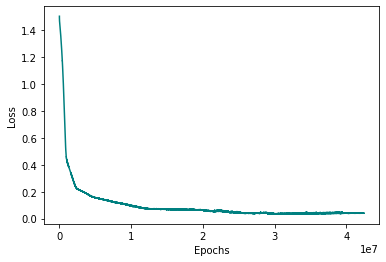

In [31]:
%%time

#this worked best
dinn = DINN(polio_data[0], polio_data[1], polio_data[2], polio_data[3], polio_data[4], polio_data[5], polio_data[6])

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.9, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=1000, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-7, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.95, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  Sc_pred_list  ,Sa_pred_list  ,Ic_pred_list  ,Ia_pred_list  ,Rc_pred_list  ,Ra_pred_list  = dinn.train(61) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    Sc_pred_list  ,Sa_pred_list  ,Ic_pred_list  ,Ia_pred_list  ,Rc_pred_list  ,Ra_pred_list  = dinn.train(61) #train
  elif dinn.save == 3:
    dinn.save = 2
    Sc_pred_list  ,Sa_pred_list  ,Ic_pred_list  ,Ia_pred_list  ,Rc_pred_list  ,Ra_pred_list  = dinn.train(61) #train

Text(0, 0.5, 'Loss')

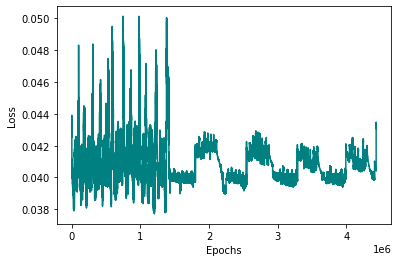

In [32]:
plt.plot(dinn.losses[38000000:], color = 'teal')  
plt.xlabel('Epochs')
plt.ylabel('Loss')

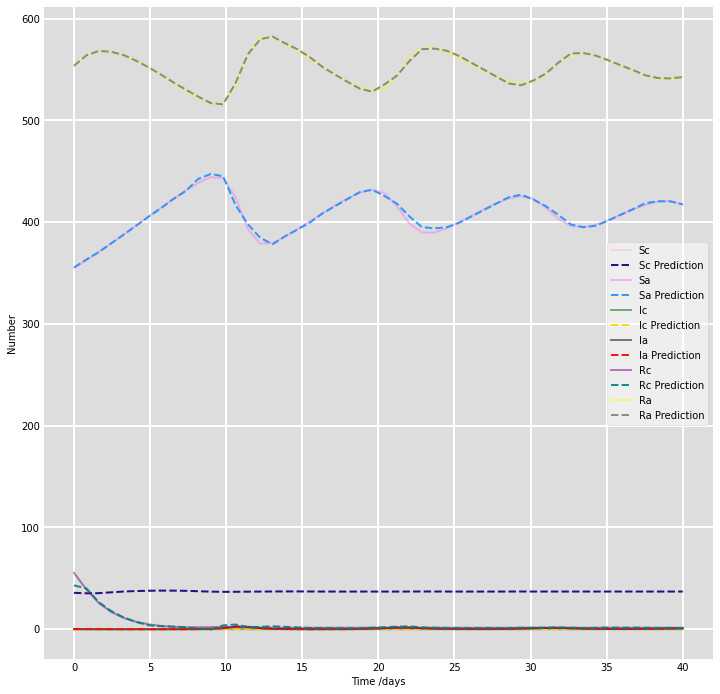

In [42]:
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(polio_data[0], polio_data[1], 'pink', alpha=0.5, lw=2, label='Sc')
ax.plot(polio_data[0], Sc_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='Sc Prediction', linestyle='dashed')

ax.plot(polio_data[0], polio_data[2], 'violet', alpha=0.5, lw=2, label='Sa')
ax.plot(polio_data[0], Sa_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Sa Prediction', linestyle='dashed')

ax.plot(polio_data[0], polio_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ic')
ax.plot(polio_data[0], Ic_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Ic Prediction', linestyle='dashed')

ax.plot(polio_data[0], polio_data[4], 'black', alpha=0.5, lw=2, label='Ia')
ax.plot(polio_data[0], Ia_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Ia Prediction', linestyle='dashed')

ax.plot(polio_data[0], polio_data[5], 'purple', alpha=0.5, lw=2, label='Rc')
ax.plot(polio_data[0], Rc_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Rc Prediction', linestyle='dashed')

ax.plot(polio_data[0], polio_data[6], 'yellow', alpha=0.5, lw=2, label='Ra')
ax.plot(polio_data[0], Ra_pred_list[0].detach().numpy(), 'grey', alpha=0.9, lw=2, label='Ra Prediction', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

tensor([0.0200], grad_fn=<AddBackward0>)
tensor([0.5018], grad_fn=<AddBackward0>)
tensor([18.0246], grad_fn=<AddBackward0>)
tensor([36.0701], grad_fn=<AddBackward0>)
tensor([40.2510], grad_fn=<AddBackward0>)
tensor([90.6050], grad_fn=<AddBackward0>)
tensor([0.0002], grad_fn=<MulBackward0>)
tensor([0.0004], grad_fn=<MulBackward0>)


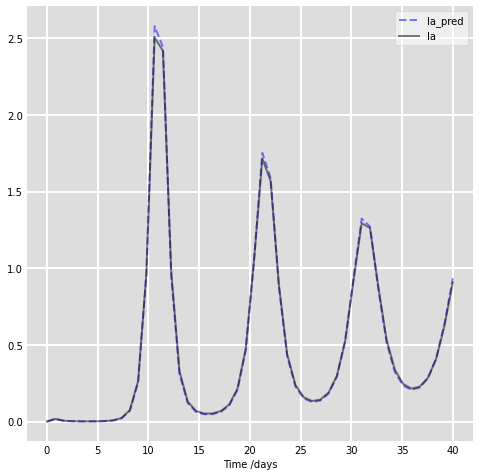

In [34]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
Sc0 = 0.0355 * 1000
Sa0 = 0.3550 * 1000
Ic0 = 0.0003 * 1000
Ia0 = 0 * 1000
Rc0 = 0.0554 * 1000
Ra0 = 0.5538 * 1000
Na = Sa0 + Ia0 + Ra0
Nc = Sc0 + Ic0 + Rc0
N = Nc + Na 

# A grid of time points (in days)
t = np.linspace(0, 40, 50) 

#parameters
mu = dinn.mu 
alpha = dinn.alpha 
gamma_a = 18.1 #dinn.gamma_a 
gamma_c = 36.2 #dinn.gamma_c 
beta_aa = dinn.beta_aa 
beta_cc = dinn.beta_cc 
beta_ac = dinn.beta_ac 
beta_ca = dinn.beta_ca 

print(dinn.mu)
print(dinn.alpha)
print(dinn.gamma_a)
print(dinn.gamma_c)
print(dinn.beta_aa)
print(dinn.beta_cc)
print(dinn.beta_ac)
print(dinn.beta_ca)

# The SIR model differential equations.
def deriv(y, t, N, Nc, Na, mu ,alpha ,gamma_a ,gamma_c ,beta_aa ,beta_cc ,beta_ac ,beta_ca):
    Sc  ,Sa  ,Ic  ,Ia  ,Rc  ,Ra = y
 
    dScdt = mu*N - (alpha+mu+(beta_cc/Nc) *Ic + (beta_ca/Nc) *Ia) * Sc
    dSadt = alpha*Sc - (mu + (beta_aa/Na)*Ia + (beta_ac/Na)*Ic)*Sa
    dIcdt = ((beta_cc/Nc)*Ic + (beta_ca/Nc)*Ia)*Sc - (gamma_c+alpha+mu)*Ic
    dIadt = ((beta_ac/Na)*Ic + (beta_aa/Na)*Ia)*Sa - (gamma_a+mu)*Ia +alpha*Ic
    dRcdt = gamma_c*Ic - mu*Rc - alpha*Rc
    dRadt = gamma_a*Ia - mu*Ra + alpha*Rc

    return  dScdt  ,dSadt  ,dIcdt  ,dIadt  ,dRcdt  ,dRadt 


# Initial conditions vector
y0 = Sc0  ,Sa0  ,Ic0  ,Ia0  ,Rc0  ,Ra0 
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, Nc, Na, mu ,alpha ,gamma_a ,gamma_c ,beta_aa ,beta_cc ,beta_ac ,beta_ca))
Sc  ,Sa  ,Ic  ,Ia  ,Rc  ,Ra  = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w', figsize=(8,8))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

# ax.plot(t, Sc, 'violet', alpha=0.5, lw=2, label='Sc_pred', linestyle='dashed')
# ax.plot(polio_data[0], polio_data[1], 'black', alpha=0.5, lw=2, label='Sc')

# ax.plot(t, Sa, 'black', alpha=0.5, lw=2, label='Sa_pred', linestyle='dashed')
# ax.plot(polio_data[0], polio_data[2], 'violet', alpha=0.5, lw=2, label='Sa')

# ax.plot(t, Ic, 'darkgreen', alpha=0.5, lw=2, label='Ic_pred', linestyle='dashed')
# ax.plot(polio_data[0], polio_data[3], 'purple', alpha=0.5, lw=2, label='Ic')

ax.plot(t, Ia, 'blue', alpha=0.5, lw=2, label='Ia_pred', linestyle='dashed')
ax.plot(polio_data[0], polio_data[4], 'black', alpha=0.5, lw=2, label='Ia')

# ax.plot(t, Rc, 'yellow', alpha=0.5, lw=2, label='Rc_pred', linestyle='dashed')
# ax.plot(polio_data[0], polio_data[5], 'purple', alpha=0.5, lw=2, label='Rc')

# ax.plot(t, Ra, 'red', alpha=0.5, lw=2, label='Ra_pred', linestyle='dashed')
# ax.plot(polio_data[0], polio_data[6], 'yellow', alpha=0.5, lw=2, label='Ra')


ax.set_xlabel('Time /days')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [35]:
Sc_total_loss = 0
Sc_den = 0
Sa_total_loss = 0
Sa_den = 0
Ic_total_loss = 0
Ic_den = 0
Ia_total_loss = 0
Ia_den = 0
Rc_total_loss = 0
Rc_den = 0
Ra_total_loss = 0
Ra_den = 0

for timestep in range(len(t)):
    Sc_value = polio_data[1][timestep] - Sc[timestep]
    Sc_total_loss += Sc_value**2
    Sc_den += (polio_data[1][timestep])**2

    Sa_value = polio_data[2][timestep] - Sa[timestep]
    Sa_total_loss += Sa_value**2
    Sa_den += (polio_data[2][timestep])**2
    
    Ic_value = polio_data[3][timestep] - Ic[timestep]
    Ic_total_loss += Ic_value**2
    Ic_den += (polio_data[3][timestep])**2
    
    Ia_value = polio_data[4][timestep] - Ia[timestep]
    Ia_total_loss += Ia_value**2
    Ia_den += (polio_data[4][timestep])**2
    
    Rc_value = polio_data[5][timestep] - Rc[timestep]
    Rc_total_loss += Rc_value**2
    Rc_den += (polio_data[5][timestep])**2
    
    Ra_value = polio_data[6][timestep] - Ra[timestep]
    Ra_total_loss += Ra_value**2
    Ra_den += (polio_data[6][timestep])**2

Sc_total_loss = math.sqrt(Sc_total_loss/Sc_den)
Sa_total_loss = math.sqrt(Sa_total_loss/Sa_den)
Ic_total_loss = math.sqrt(Ic_total_loss/Ic_den)
Ia_total_loss = math.sqrt(Ia_total_loss/Ia_den)
Rc_total_loss = math.sqrt(Rc_total_loss/Rc_den)
Ra_total_loss = math.sqrt(Ra_total_loss/Ra_den)

print('Sc_total_loss', Sc_total_loss)
print('Sa_total_loss', Sa_total_loss)
print('Ic_total_loss', Ic_total_loss)
print('Ia_total_loss', Ia_total_loss)
print('Rc_total_loss', Rc_total_loss)
print('Ra_total_loss', Ra_total_loss)


Sc_total_loss 0.001420548708984788
Sa_total_loss 0.0010909158438392901
Ic_total_loss 0.0177934919362859
Ia_total_loss 0.02164103991764757
Rc_total_loss 0.004780805797046847
Ra_total_loss 0.000887183974020979
